In [ ]:
from torch import nn
from torch.nn.functional import relu
import torch
import os
from sklearn.model_selection import train_test_split
from random import seed, shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = 'mps'
DATASET_PATH = f'../pt_ekyn'
WINDOW_SIZE = 9

class ResidualBlock(nn.Module):
    def __init__(self,in_feature_maps,out_feature_maps,n_features) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(in_feature_maps,out_feature_maps,kernel_size=8,padding='same',bias=False)
        self.bn1 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

        self.c2 = nn.Conv1d(out_feature_maps,out_feature_maps,kernel_size=5,padding='same',bias=False)
        self.bn2 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

        self.c3 = nn.Conv1d(out_feature_maps,out_feature_maps,kernel_size=3,padding='same',bias=False)
        self.bn3 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

        self.c4 = nn.Conv1d(in_feature_maps,out_feature_maps,1,padding='same',bias=False)
        self.bn4 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

    def forward(self,x):
        identity = x
        x = self.c1(x)
        x = self.bn1(x)
        x = relu(x)

        x = self.c2(x)
        x = self.bn2(x)
        x = relu(x)

        x = self.c3(x)
        x = self.bn3(x)
        x = relu(x)

        identity = self.c4(identity)
        identity = self.bn4(identity)

        x = x+identity
        x = relu(x)
        
        return x
class Frodo(nn.Module):
    def __init__(self,n_features,device='cuda') -> None:
        super().__init__()
        self.n_features = n_features
        self.block1 = ResidualBlock(1,8,n_features).to(device)
        self.block2 = ResidualBlock(8,16,n_features).to(device)
        self.block3 = ResidualBlock(16,16,n_features).to(device)

        self.gap = nn.AvgPool1d(kernel_size=n_features)
        self.fc1 = nn.Linear(in_features=16,out_features=3)
    def forward(self,x,classification=True):
        x = x.view(-1,1,self.n_features)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        if(classification):
            x = self.fc1(x.squeeze())
            return x
        else:
            return x.squeeze()
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000,device=DEVICE).to(DEVICE)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = torch.Tensor().to(DEVICE)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
def get_ids():
    return sorted([id.split("_")[0] for id in os.listdir(DATASET_PATH) if "PF" in id])
def get_leave_one_out_cv_ids_for_ekyn():
    ids = get_ids()
    seed(0)
    shuffle(ids)
    ret = []
    for test_id in ids:
        train_ids = [x for x in ids if x != test_id]
        ret.append((train_ids, [test_id]))
    return ret
def load_eeg_label_pair(id,condition):
    X,y = torch.load(f'{DATASET_PATH}/{id}_{condition}.pt',weights_only=False)
    X = torch.cat([torch.zeros(WINDOW_SIZE//2,5000),X,torch.zeros(WINDOW_SIZE//2,5000)])
    return (X,y)
def evaluate(dataloader,model,criterion,device='mps'):
    model.eval()
    model.to(device)
    with torch.no_grad():
        loss_total = 0
        y_true = []
        y_pred = []
        for Xi,yi in tqdm(dataloader):
            Xi,yi = Xi.to(device),yi.to(device)
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()

            y_true.append(yi.argmax(axis=1).cpu())
            y_pred.append(logits.softmax(dim=1).argmax(axis=1).cpu())
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    return loss_total/len(dataloader),y_true,y_pred
class SSDataset(torch.utils.data.Dataset):
    def __init__(self,Xs,ys,idx) -> None:
        super().__init__()
        self.Xs = Xs
        self.ys = ys
        self.idx = idx
    def __len__(self):
        return len(self.idx)
    def __getitem__(self, index):
        index = self.idx[index]
        return (self.Xs[index // 8640][(index % 8640) : (index % 8640) + 9].flatten(),self.ys[index // 8640][index % 8640])

In [ ]:
FOLD = 0
folds = get_leave_one_out_cv_ids_for_ekyn()
train_ids,test_ids = folds[FOLD]
print(train_ids,test_ids)
subjects = [load_eeg_label_pair(id=id,condition=condition) for id in train_ids for condition in ['Vehicle','PF']]
Xs = [subject[0] for subject in subjects]
ys = [subject[1] for subject in subjects]
train_idx,test_idx = train_test_split(range(len(subjects)*8640),test_size=.1,random_state=0,shuffle=True)
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=SSDataset(Xs,ys,train_idx),batch_size=128,shuffle=True)
devloader = DataLoader(dataset=SSDataset(Xs,ys,test_idx),batch_size=32,shuffle=True)
del subjects
del Xs
del ys
print(f'trainloader: {len(trainloader)} batches')
print(f'devloader: {len(devloader)} batches')
model = Gandalf()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [ ]:
model.to(DEVICE)
lossi = []
# for i in range(1):
for Xi,yi in tqdm(trainloader):
    Xi,yi = Xi.to(DEVICE),yi.to(DEVICE)
    logits = model(Xi)
    loss = criterion(logits,yi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

In [ ]:
plt.plot(lossi)

In [ ]:
loss,y_true,y_pred = evaluate(trainloader,model,criterion)
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))

In [ ]:
class Windowset(torch.utils.data.Dataset):
    def __init__(self,X,y):
        self.X = torch.cat([torch.zeros(4,5000),X,torch.zeros(4,5000)])
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx:idx+9].flatten(),self.y[idx])
X,y = load_eeg_label_pair(id=test_ids[0],condition='Vehicle')
testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)

100%|██████████| 270/270 [00:09<00:00, 27.20it/s]


              precision    recall  f1-score   support

           0       0.75      0.13      0.22       462
           1       0.85      0.85      0.85      4311
           2       0.80      0.87      0.83      3867

    accuracy                           0.82      8640
   macro avg       0.80      0.62      0.63      8640
weighted avg       0.82      0.82      0.81      8640



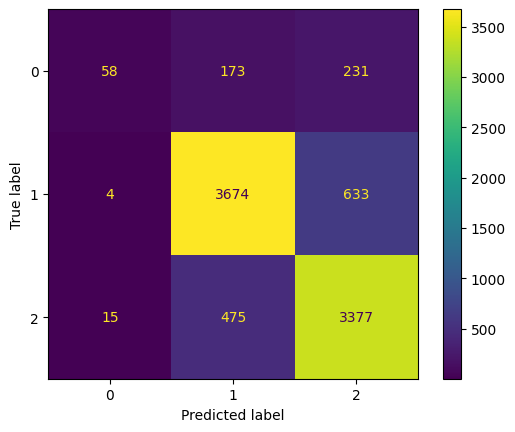

In [14]:
loss,y_true,y_pred = evaluate(testloader,model,criterion)
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
print(classification_report(y_true,y_pred))